## Objectives

In this assignment we would try to cluster documents from the (in)famous [20-newsgroups dataset](http://qwone.com/~jason/20Newsgroups/).  



In [125]:
from sklearn.datasets import fetch_20newsgroups
categories = [
    'alt.atheism',
    'rec.autos',
    'sci.space',
    'comp.graphics'
]

In [126]:
newsgroups_train = fetch_20newsgroups(subset='train',categories=categories, shuffle=True)

In [127]:
from pprint import pprint
pprint(list(newsgroups_train.target_names))

['alt.atheism', 'comp.graphics', 'rec.autos', 'sci.space']


In [5]:
# rep = {
#      0 : [1,2,3,4,5]
#     ,1 : [7,8,9,10]
#     ,2 : [11,12,13,14]
#     ,3 : [16,17,18]
#     ,4 : [0,19,15]
#     ,5 : [6]
#     }
# # 0 - comp , 1 - rec , 2 - sci , 3 - talk , 4 - reli , 5 - misc

# inv_rep = {}
# for (k,v) in rep.items():
#     for vi in v:
#         inv_rep[vi] = k
        


In [6]:
# newsgroups_train.target = list(map(inv_rep.get, newsgroups_train.target))

In [128]:
import collections

collections.Counter(newsgroups_train.target)

Counter({2: 594, 3: 593, 1: 584, 0: 480})

In [8]:
# import random
# def sample(each, news, target):
    
#     inv = collections.defaultdict(list)
    
#     for i in range(len(news)):
#         inv[target[i]].append(i)
    
#     sampled_data = []
#     sampled_target = []
    
#     for (k, v) in inv.items():
#         for i in random.sample(v, each):
#             sampled_data.append(news[i])
#             sampled_target.append(k)
            
#     return sampled_data, sampled_target

# news_data, news_target = sample(500, newsgroups_train.data, newsgroups_train.target)

## Feature extraction 


In [129]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.6, max_features=2500,
                             min_df=2, stop_words='english'
                             )

X = vectorizer.fit_transform(newsgroups_train.data)


CPU times: user 495 ms, sys: 2 µs, total: 495 ms
Wall time: 493 ms


In [130]:
print(X.shape)

(2251, 2500)


## K-means clustering

From https://github.com/kulraghav/MLPractice/blob/master/Notebooks/unsupervised.ipynb

In [131]:
%%time
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

CLUSTERS = 4
# kmeans = KMeans(n_clusters=CLUSTERS, random_state=4)

kmeans = MiniBatchKMeans(n_clusters=CLUSTERS, init='k-means++' ,
                         init_size=600, batch_size=100)

clusters = kmeans.fit_predict(X)
print(kmeans.cluster_centers_.shape)

(4, 2500)
CPU times: user 94 ms, sys: 2 µs, total: 94 ms
Wall time: 90.9 ms


In [132]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

from scipy.stats import mode

print(news_target[:10])
print(clusters[:10])

print(X.shape)

labels = np.zeros_like(clusters)
target = np.array(newsgroups_train.target)

for i in range(CLUSTERS):
    mask = (clusters == i)
    labels[mask] = mode(target[mask])[0]
    
from sklearn.metrics import accuracy_score
accuracy_score(target, labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2 3 2 2 2 2 1 0 2 0]
(2251, 2500)


0.7840959573522879

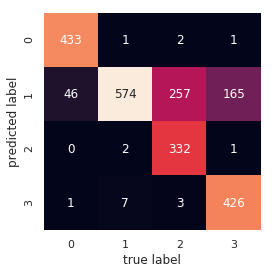

In [133]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=range(CLUSTERS),
            yticklabels=range(CLUSTERS))
plt.xlabel('true label')
plt.ylabel('predicted label');

## K means with PCA

In [142]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


svd = TruncatedSVD(500)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X_ = lsa.fit_transform(X)


import pandas as pd
from sklearn.preprocessing import StandardScaler



scaler = StandardScaler()


news_scaled = scaler.fit_transform(X_)

from sklearn.decomposition import PCA

"""
    pca can also be initialized as pca = pca(0.95) : fraction of variance explained
"""


from sklearn.decomposition import PCA

pca = PCA(n_components=10)

principal_components = pca.fit_transform(news_scaled)
                    
news_proj = pd.DataFrame(data = principal_components)

kmeans = KMeans(n_clusters=CLUSTERS, random_state=4)
clusters = kmeans.fit_predict(news_proj)

labels = np.zeros_like(clusters)
target = np.array(newsgroups_train.target)

for i in range(CLUSTERS):
    mask = (clusters == i)
    labels[mask] = mode(target[mask])[0]


In [143]:
accuracy_score(target, labels)

0.33140826299422477

## t-SNE

In [144]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
news_proj = tsne.fit_transform(X_)

# Compute the clusters
kmeans = KMeans(n_clusters=CLUSTERS, random_state=4)
clusters = kmeans.fit_predict(news_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(CLUSTERS):
    mask = (clusters == i)
    labels[mask] = mode(target[mask])[0]

# Compute the accuracy
accuracy_score(target, labels)

0.7965348733896046

In [145]:
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
proj = pd.DataFrame(news_proj)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = labels
sns.lmplot("comp_1", "comp_2", hue = "labels", data = proj.sample(1000) ,fit_reg=False)
print("ready")

NameError: name 'matplotlib' is not defined